In [1]:
%matplotlib inline
%config Completer.use_jedi = False


# Plotting data from a file

Plotting CPU usage values


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np
import pandas as pd

from glob import glob
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

Load the data
============

In [3]:
state_transitions = pd.read_csv('state_snapshots_adaptive_2021_01_25.csv')
state_transitions.head()

,name,time,placementAction,cpuUsageMetrics,arrivalRate,throughput,placementType,proxyNumaDistances
0,state_snapshots,1611548919396000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.122, 0.02, 0.238, 0.028, 0.317, 0.447, 0.97...",19630.116667,173443.56,0,"[0.15896508665521947, 0.5304177408298308, 0.47..."
1,state_snapshots,1611548949310000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.02, 0.044, 0.01, 0.99, 0.067, 0.012, 0.05, ...",40117.483333,354641.70,3,"[0.15914964924399916, 0.5305265121060809, 0.47..."
2,state_snapshots,1611548979314000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.018, 0.024, 0.442, 0.801, 0.016, 0.024, 0.8...",39166.200000,345431.02,3,"[0.15342101344150996, 0.5139038184874231, 0.46..."
3,state_snapshots,1611549009297000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.008, 0.016, 0.03, 0.062, 0.032, 0.008, 0.06...",38181.850000,337596.13,3,"[0.1519832873035189, 0.5072371116132921, 0.456..."
4,state_snapshots,1611549039311000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.036, 0.08, 0.004, 0.468, 0.301, 0.006, 0.03...",39256.966667,347953.80,3,"[0.46251032829239985, 0.5257452260208483, 0.47..."


In [4]:
start_time = state_transitions['time'].iloc[0]
placement_actions = state_transitions.placementAction.str.strip(
    '[]').str.split(',', expand=True).astype(int)
placement_actions = placement_actions.add_prefix('v')
n_vertices = placement_actions.shape[1]

proxy_numa_distances = state_transitions.proxyNumaDistances.str.strip(
    '[]').str.split(',', expand=True).astype(float)
proxy_numa_distances = proxy_numa_distances.add_prefix('numa_')
proxy_numa_distances['numaSum'] = proxy_numa_distances.sum(axis=1)

for op_column in placement_actions:
    one_hot_encoded_placement = pd.get_dummies(placement_actions[op_column], prefix= "op_" + op_column + "_cpu")
    placement_actions = placement_actions.join(one_hot_encoded_placement)
cpu_metrics = state_transitions.cpuUsageMetrics.str.strip('[]').str.split(',', expand=True)
cpu_metrics = cpu_metrics.add_prefix('cpu_')
processed_state_transitions = state_transitions.join(placement_actions).join(
    cpu_metrics).join(proxy_numa_distances)
processed_state_transitions['relTime'] =  ((processed_state_transitions['time'] - 
                                            start_time)/30_000_000_000).round().astype(int)
processed_state_transitions

,name,time,placementAction,cpuUsageMetrics,arrivalRate,throughput,placementType,proxyNumaDistances,v0,v1,...,numa_58,numa_59,numa_60,numa_61,numa_62,numa_63,numa_64,numa_65,numaSum,relTime
0,state_snapshots,1611548919396000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.122, 0.02, 0.238, 0.028, 0.317, 0.447, 0.97...",19630.116667,173443.56,0,"[0.15896508665521947, 0.5304177408298308, 0.47...",1,2,...,0.625019,0.212172,0.053044,0.795648,0.318253,0.318251,0.689571,1.000000,38.933917,0
1,state_snapshots,1611548949310000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.02, 0.044, 0.01, 0.99, 0.067, 0.012, 0.05, ...",40117.483333,354641.70,3,"[0.15914964924399916, 0.5305265121060809, 0.47...",2,17,...,0.625014,0.212115,0.053026,0.795436,0.318166,0.318160,0.689373,1.000000,38.100092,1
2,state_snapshots,1611548979314000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.018, 0.024, 0.442, 0.801, 0.016, 0.024, 0.8...",39166.200000,345431.02,3,"[0.15342101344150996, 0.5139038184874231, 0.46...",19,13,...,0.605874,0.202871,0.050716,0.760773,0.304303,0.304297,0.659334,0.967491,35.747188,2
3,state_snapshots,1611549009297000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.008, 0.016, 0.03, 0.062, 0.032, 0.008, 0.06...",38181.850000,337596.13,3,"[0.1519832873035189, 0.5072371116132921, 0.456...",14,23,...,0.579885,0.200884,0.190469,0.753338,0.301328,0.301326,0.652887,0.934856,35.939679,3
4,state_snapshots,1611549039311000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.036, 0.08, 0.004, 0.468, 0.301, 0.006, 0.03...",39256.966667,347953.80,3,"[0.46251032829239985, 0.5257452260208483, 0.47...",14,17,...,0.665638,0.210882,0.052721,0.790825,0.711058,0.521430,0.685379,0.945341,37.940289,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
719,state_snapshots,1611577479525000000,"[6, 10, 23, 8, 11, 2, 1, 20, 0, 16, 18, 22, 17...","[0.018, 0.271, 0.838, 0.056, 0.004, 0.006, 0.9...",34587.633333,318421.58,1,"[0.3992839781027944, 0.46766935503593915, 0.93...",6,10,...,0.894329,0.802345,0.269428,0.894131,0.553626,0.278428,0.713098,0.940681,48.596421,952
720,state_snapshots,1611577539476000000,"[6, 18, 19, 8, 20, 3, 2, 14, 0, 4, 1, 5, 17, 1...","[0.022, 0.279, 0.974, 0.064, 0.008, 0.006, 0.0...",38863.150000,350666.90,1,"[0.4535713919430969, 0.4614274365138033, 0.576...",6,18,...,0.817270,0.618263,0.758981,0.705143,0.651421,0.698759,0.611118,0.948046,46.945397,954
721,state_snapshots,1611577569397000000,"[13, 14, 15, 5, 4, 2, 1, 20, 0, 16, 18, 22, 17...","[0.008, 0.275, 0.99, 0.052, 0.004, 0.006, 0.01...",38026.783333,350410.28,1,"[0.3992839781027944, 0.46766935503593915, 0.93...",13,14,...,0.891232,0.802345,0.269428,0.894131,0.553626,0.278428,0.713098,0.911107,48.206151,955
722,state_snapshots,1611577599494000000,"[6, 10, 23, 8, 11, 2, 1, 20, 0, 16, 18, 22, 17...","[0.03, 0.278, 0.992, 0.066, 0.002, 0.002, 0.01...",38272.450000,352450.50,1,"[0.3992839781027944, 0.46766935503593915, 0.93...",6,10,...,0.894329,0.802345,0.269428,0.894131,0.553626,0.278428,0.713098,0.940681,48.596421,956


In [37]:
placementTypeNames = {0:'Default',1:'Predicted-First',2:'Predicted-Other',3:'Random',4:'Naive'}
placementTypeColors = {'Default':'C3','Predicted-First':'C0','Predicted-Other':'C5','Random':'C1','Naive':'C2'}
plot_state_transitions = processed_state_transitions.loc[:,['relTime','placementAction','placementType',
                                                            'arrivalRate','throughput','numaSum']]
plot_state_transitions['placementTypeName'] = plot_state_transitions['placementType'].map(placementTypeNames)
plot_state_transitions['placementTypeColor'] = plot_state_transitions['placementTypeName'].map(placementTypeColors)
plot_state_transitions['placementAction'] = plot_state_transitions[
    'relTime'].astype(str) + " : " + plot_state_transitions['placementAction'] 
plot_state_transitions['numaSumTime'] = plot_state_transitions[
    'relTime'].astype(str) + " : " + plot_state_transitions['numaSum'].round(1).astype(str)
plot_state_transitions

,relTime,placementAction,placementType,arrivalRate,throughput,numaSum,placementTypeName,placementTypeColor,numaSumTime
0,0,"0 : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13...",0,19630.116667,173443.56,38.933917,Default,C3,0 : 38.9
1,1,"1 : [2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4,...",3,40117.483333,354641.70,38.100092,Random,C1,1 : 38.1
2,2,"2 : [19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1...",3,39166.200000,345431.02,35.747188,Random,C1,2 : 35.7
3,3,"3 : [14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18...",3,38181.850000,337596.13,35.939679,Random,C1,3 : 35.9
4,4,"4 : [14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, ...",3,39256.966667,347953.80,37.940289,Random,C1,4 : 37.9
...,...,...,...,...,...,...,...,...,...
719,952,"952 : [6, 10, 23, 8, 11, 2, 1, 20, 0, 16, 18, ...",1,34587.633333,318421.58,48.596421,Predicted-First,C0,952 : 48.6
720,954,"954 : [6, 18, 19, 8, 20, 3, 2, 14, 0, 4, 1, 5,...",1,38863.150000,350666.90,46.945397,Predicted-First,C0,954 : 46.9
721,955,"955 : [13, 14, 15, 5, 4, 2, 1, 20, 0, 16, 18, ...",1,38026.783333,350410.28,48.206151,Predicted-First,C0,955 : 48.2
722,956,"956 : [6, 10, 23, 8, 11, 2, 1, 20, 0, 16, 18, ...",1,38272.450000,352450.50,48.596421,Predicted-First,C0,956 : 48.6


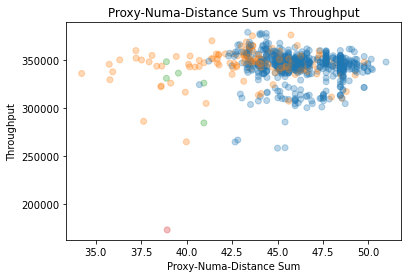

In [33]:
plt.scatter(plot_state_transitions['numaSum'], 
            plot_state_transitions['throughput'], 
            c=plot_state_transitions['placementTypeColor'], alpha=0.3)
plt.title("Proxy-Numa-Distance Sum vs Throughput")
plt.xlabel("Proxy-Numa-Distance Sum")
plt.ylabel("Throughput")
plt.savefig('proxy_numa_sum_vs_througput.png')
plt.show()

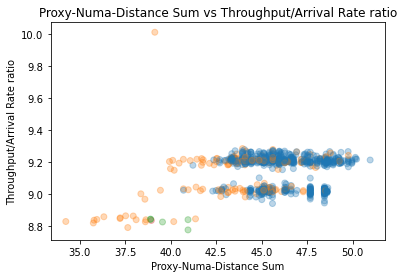

In [31]:
plt.scatter(plot_state_transitions['numaSum'], 
            plot_state_transitions['throughput'] / plot_state_transitions['arrivalRate'], 
            c=plot_state_transitions['placementTypeColor'], alpha=0.3)
plt.title("Proxy-Numa-Distance Sum vs Throughput/Arrival Rate ratio")
plt.xlabel("Proxy-Numa-Distance Sum")
plt.ylabel("Throughput/Arrival Rate ratio")
plt.savefig('proxy_numa_sum_vs_througput_arrival_rate_ratio.png')
plt.show()

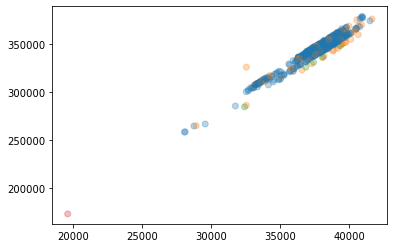

In [8]:
plt.scatter(plot_state_transitions['arrivalRate'],plot_state_transitions['throughput'],  
            c=plot_state_transitions['placementTypeColor'], alpha=0.3)
plt.show()

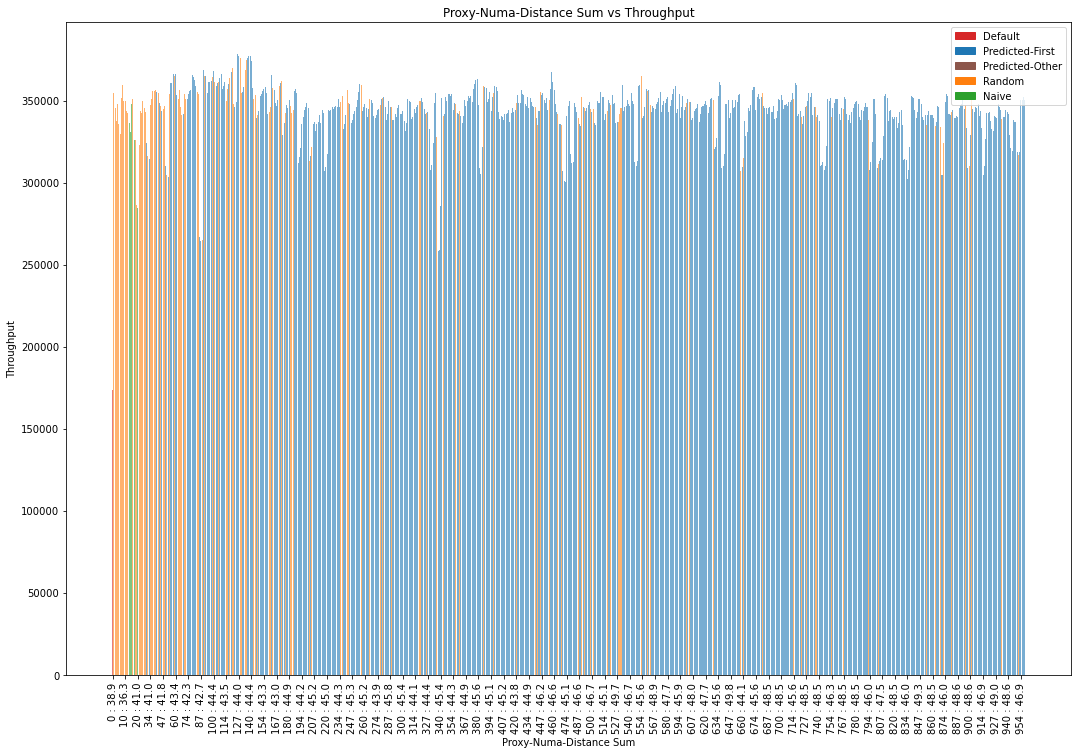

In [43]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:724]

ax.bar(subplot_data['numaSumTime'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Proxy-Numa-Distance Sum', ylabel='Throughput', title='Proxy-Numa-Distance Sum vs Throughput')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::10]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels, loc='upper right')

plt.savefig('numa_sum_highlevel.png')
plt.show()

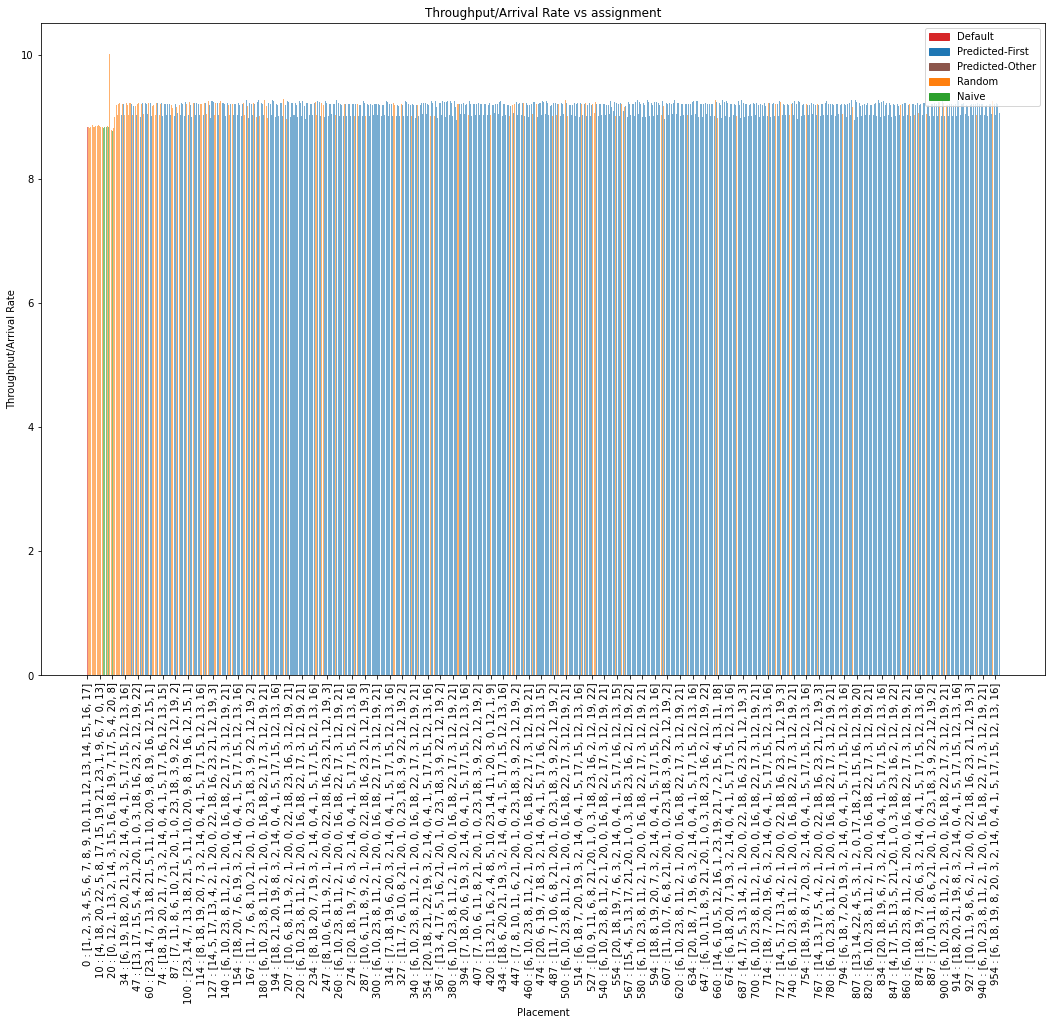

In [23]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:724]

ax.bar(subplot_data['placementAction'], subplot_data['throughput']/subplot_data['arrivalRate'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput/Arrival Rate', title='Throughput/Arrival Rate vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::10]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels, loc='upper right')

plt.savefig('placement_throughput_ratio_highlevel.png')
plt.show()

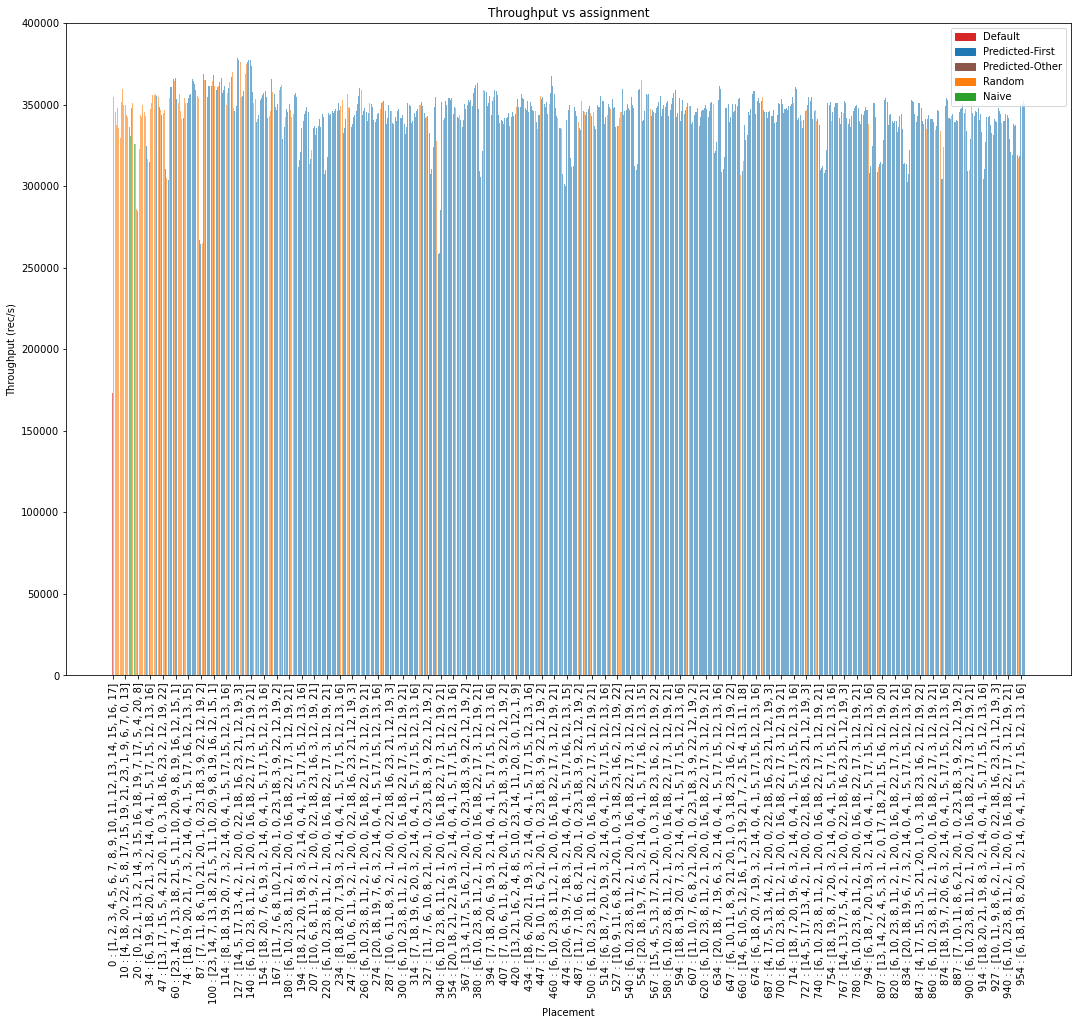

In [26]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:724]

ax.bar(subplot_data['placementAction'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::10]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)

plt.savefig('placement_throughput_highlevel.png')
plt.show()

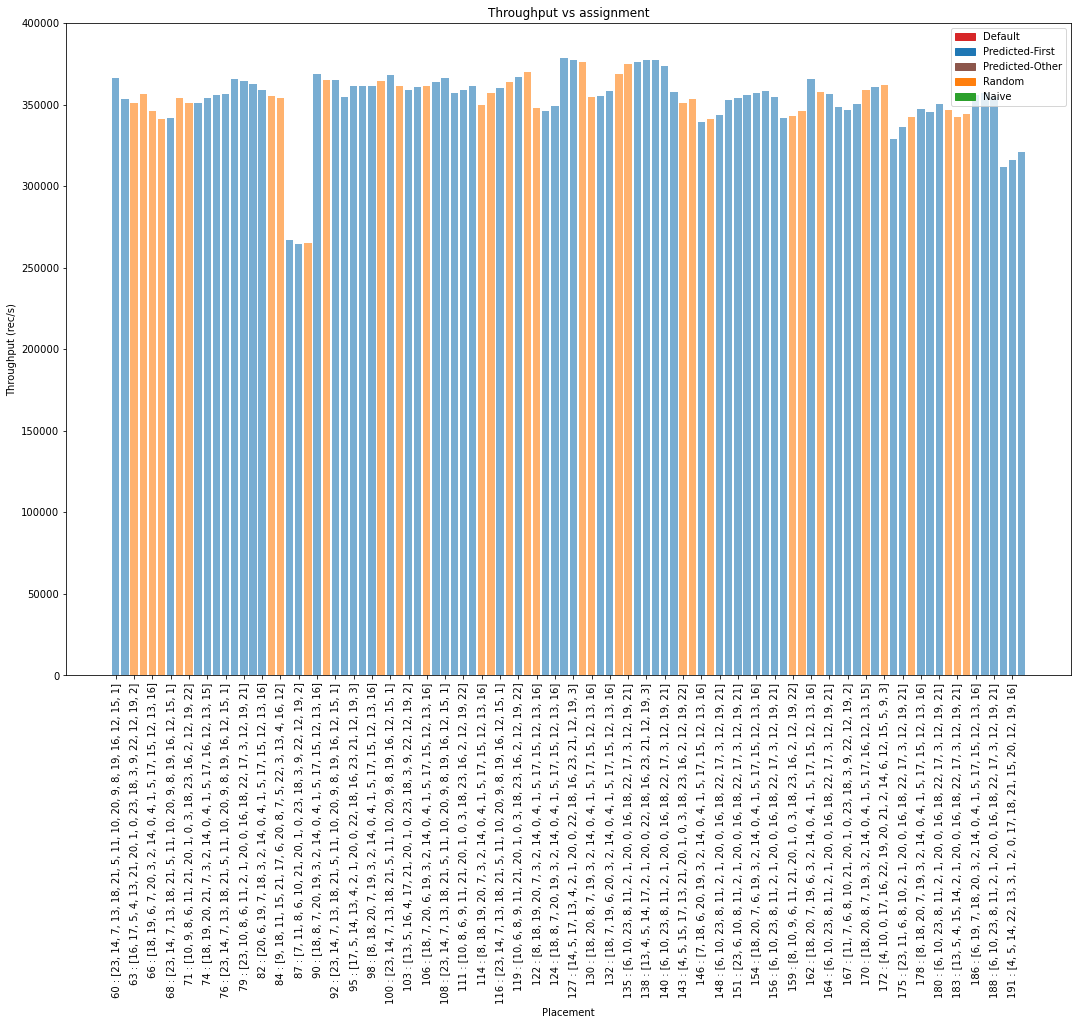

In [27]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[50:150]

ax.bar(subplot_data['placementAction'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::2]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)

plt.savefig('placement_throughput_highlevel_50_100.png')
plt.show()

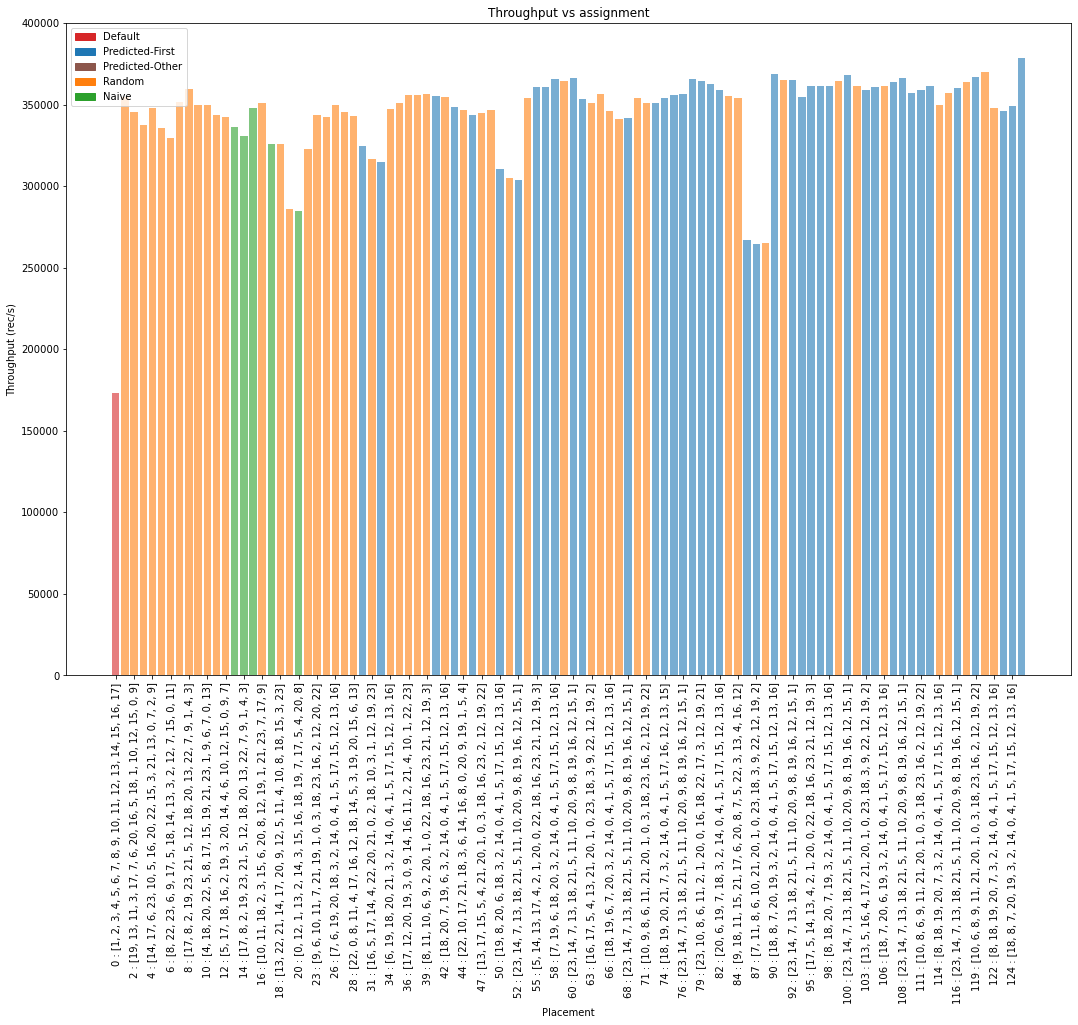

In [28]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[0:100]

ax.bar(subplot_data['placementAction'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::2]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)

plt.savefig('placement_throughput_highlevel_0_100.png')
plt.show()

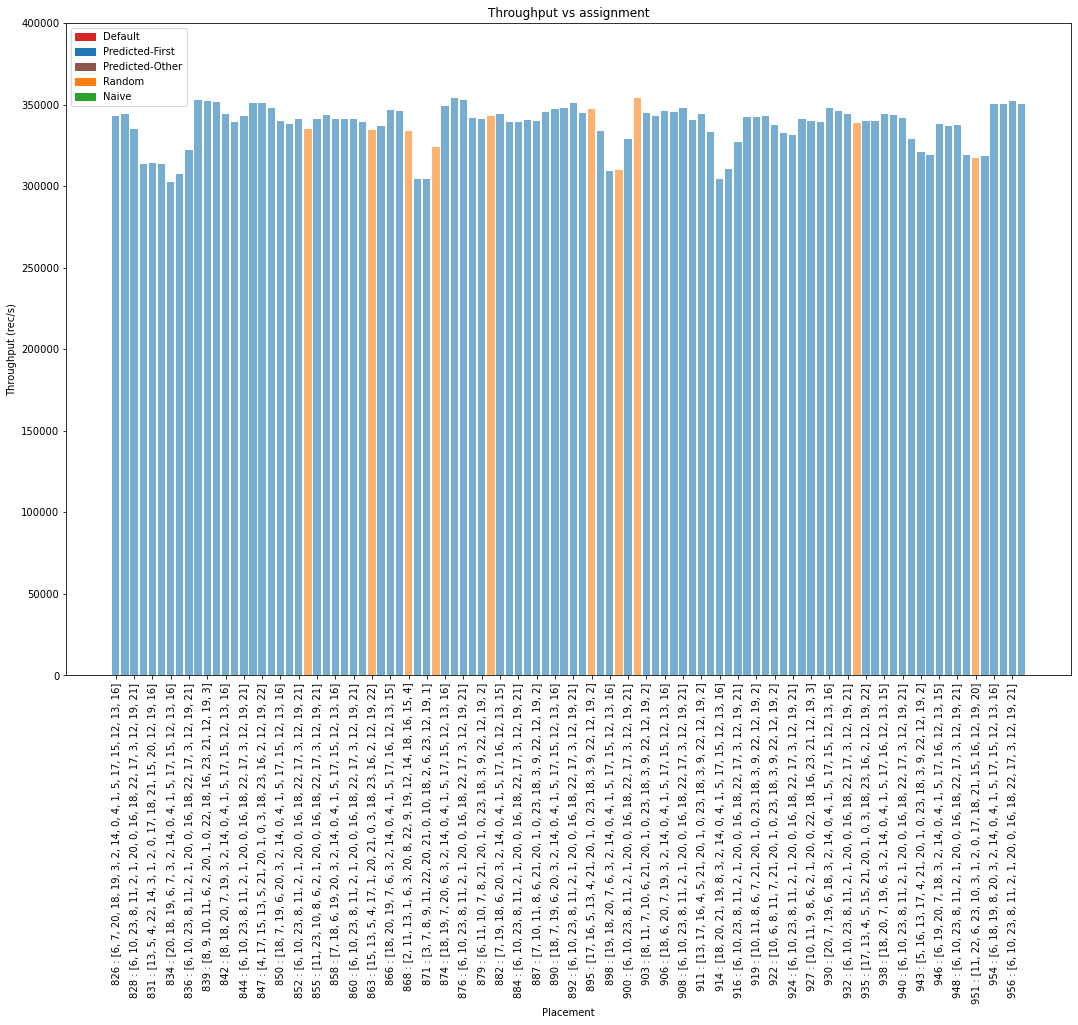

In [29]:
fig,ax = plt.subplots(figsize=(18,12))
subplot_data = plot_state_transitions.iloc[624:724]

ax.bar(subplot_data['placementAction'], subplot_data['throughput'], 
       color=subplot_data['placementTypeColor'], alpha=0.6)

ax.set(xlabel='Placement', ylabel='Throughput (rec/s)', title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=90)
x_tick_locs = ax.get_xticks()[::2]
ax.set_xticks(x_tick_locs)
leg_labels = list(placementTypeColors.keys())
leg_handles = [plt.Rectangle((0,0),1,1, color=placementTypeColors[label]) for label in leg_labels]
ax.legend(leg_handles, leg_labels)
ax.set_ylim(0,400000)


plt.savefig('placement_throughput_highlevel_624_724.png')
plt.show()

Task Manager CPU Usage
-----------



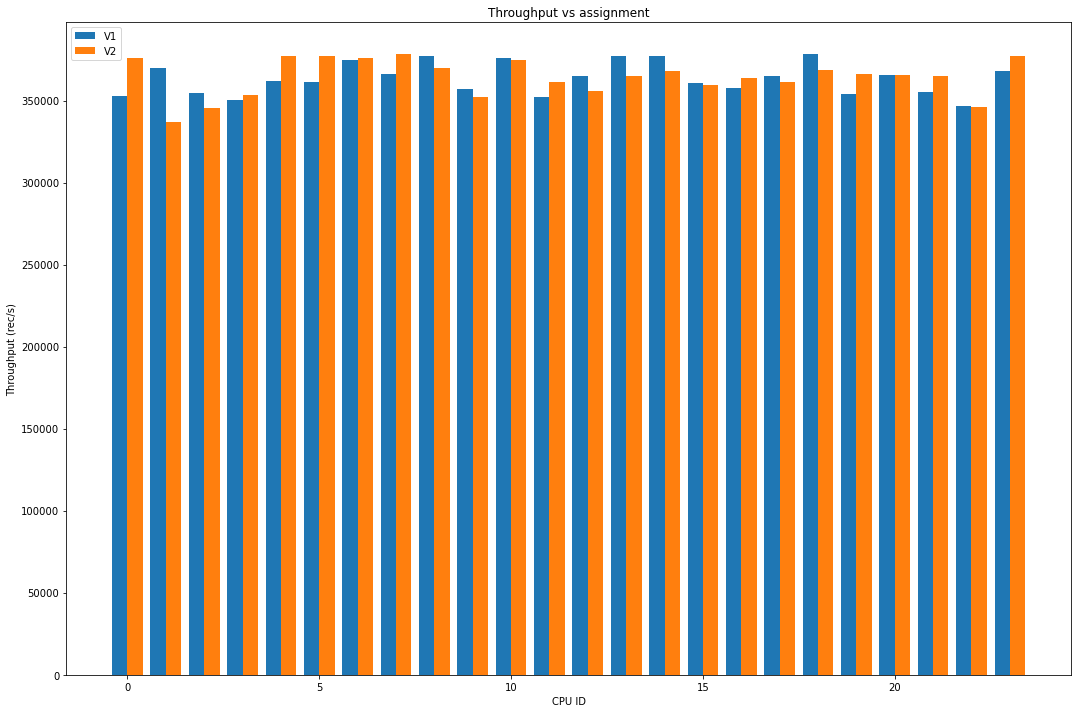

In [13]:
fig,ax = plt.subplots(figsize=(18,12))

width=0.4
ax.bar(processed_state_transitions['v0'] - width/2, processed_state_transitions['throughput'], width, label='V1')
ax.bar(processed_state_transitions['v1'] + width/2, processed_state_transitions['throughput'], width, label='V2')
#ax.plot(task_tot_cpu_data[2]['rel_time'], task_tot_cpu_data[2]['value'])
#ax.plot(task_tot_cpu_data[3]['rel_time'], task_tot_cpu_data[3]['value'])

ax.set(xlabel='CPU ID', ylabel='Throughput (rec/s)',
       title='Throughput vs assignment')
ax.tick_params(axis='x', rotation=0)
ax.legend()
plt.savefig('placement_throughput.png')
plt.show()

In [14]:
state_transitions.head()

,name,time,placementAction,cpuUsageMetrics,arrivalRate,throughput,placementType,proxyNumaDistances
0,state_snapshots,1611548919396000000,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[0.122, 0.02, 0.238, 0.028, 0.317, 0.447, 0.97...",19630.116667,173443.56,0,"[0.15896508665521947, 0.5304177408298308, 0.47..."
1,state_snapshots,1611548949310000000,"[2, 17, 19, 5, 6, 22, 15, 1, 13, 20, 9, 4, 18,...","[0.02, 0.044, 0.01, 0.99, 0.067, 0.012, 0.05, ...",40117.483333,354641.70,3,"[0.15914964924399916, 0.5305265121060809, 0.47..."
2,state_snapshots,1611548979314000000,"[19, 13, 11, 3, 17, 7, 6, 20, 16, 5, 18, 1, 10...","[0.018, 0.024, 0.442, 0.801, 0.016, 0.024, 0.8...",39166.200000,345431.02,3,"[0.15342101344150996, 0.5139038184874231, 0.46..."
3,state_snapshots,1611549009297000000,"[14, 23, 17, 4, 7, 6, 13, 15, 9, 12, 0, 18, 10...","[0.008, 0.016, 0.03, 0.062, 0.032, 0.008, 0.06...",38181.850000,337596.13,3,"[0.1519832873035189, 0.5072371116132921, 0.456..."
4,state_snapshots,1611549039311000000,"[14, 17, 6, 23, 10, 5, 16, 20, 22, 15, 3, 21, ...","[0.036, 0.08, 0.004, 0.468, 0.301, 0.006, 0.03...",39256.966667,347953.80,3,"[0.46251032829239985, 0.5257452260208483, 0.47..."


In [15]:
output_reduced_features = False

In [16]:
if not output_reduced_features:
    state_transitions_for_training = state_transitions.join(placement_actions).join(proxy_numa_distances)
    state_transitions_for_training.drop(columns=state_transitions_for_training.columns[0:4], inplace=True)
    filtered_state_transitions = state_transitions_for_training.loc[state_transitions_for_training['throughput'] > 0.0]
    throughput_col = filtered_state_transitions.pop('throughput')
    filtered_state_transitions.insert(0, 'throughput', throughput_col)
    filtered_state_transitions.drop(columns=filtered_state_transitions.columns[2:4+n_vertices], inplace=True)
    filtered_state_transitions.to_csv('state_transitions_cured.csv', index=False)
    filtered_state_transitions

In [17]:
if not output_reduced_features:
    state_trans_train, state_trans_test = train_test_split(filtered_state_transitions, test_size=0.171)
    state_trans_train.to_csv('state_transitions_cured_train.csv', index=False)
    state_trans_test_final = state_trans_test.drop(columns=['throughput'])
    state_trans_test_final.to_csv('state_transitions_cured_test.csv', index=False)
    state_trans_train

In [18]:
if output_reduced_features:
    state_transitions_for_training = state_transitions.join(placement_actions).join(proxy_numa_distances)
    state_transitions_for_training.drop(columns=state_transitions_for_training.columns[0:4], inplace=True)
    filtered_state_transitions = state_transitions_for_training.loc[state_transitions_for_training['throughput'] > 0.0]
    throughput_col = filtered_state_transitions.pop('throughput')
    filtered_state_transitions.insert(0, 'throughput', throughput_col)
    filtered_state_transitions.drop(columns=filtered_state_transitions.columns[2:4], inplace=True)
    filtered_state_transitions.drop(columns=filtered_state_transitions.columns[
        2+n_vertices:2+n_vertices+(n_vertices*23)+1+66], inplace=True)
    filtered_state_transitions.to_csv('state_transitions_cured.csv', index=False)
    filtered_state_transitions.head(10)

In [19]:
if output_reduced_features:
    state_trans_train, state_trans_test = train_test_split(filtered_state_transitions, test_size=0.171)
    state_trans_train.to_csv('state_transitions_cured_train.csv', index=False)
    state_trans_test_final = state_trans_test.drop(columns=['throughput'])
    state_trans_test_final.to_csv('state_transitions_cured_test.csv', index=False)
    state_trans_train

In [20]:
print("Done.")

Done.
